In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyarrow

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import re

from numba import jit
from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Here, I work on the dataset.

In [0]:
labels_df = pd.read_feather(f'{PATH_LABELS}/labels_df')

labels_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [0]:
train_df = pd.read_feather(f'{PATH_FEATURES}/train')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941


In [0]:
len(train_df)

16135561

## EDA

In [0]:
ids = train_df['bookingID'].unique().tolist()

len(ids)

20000

In [0]:
features = [c for c in train_df.columns if c not in ['label', 'bookingID']]

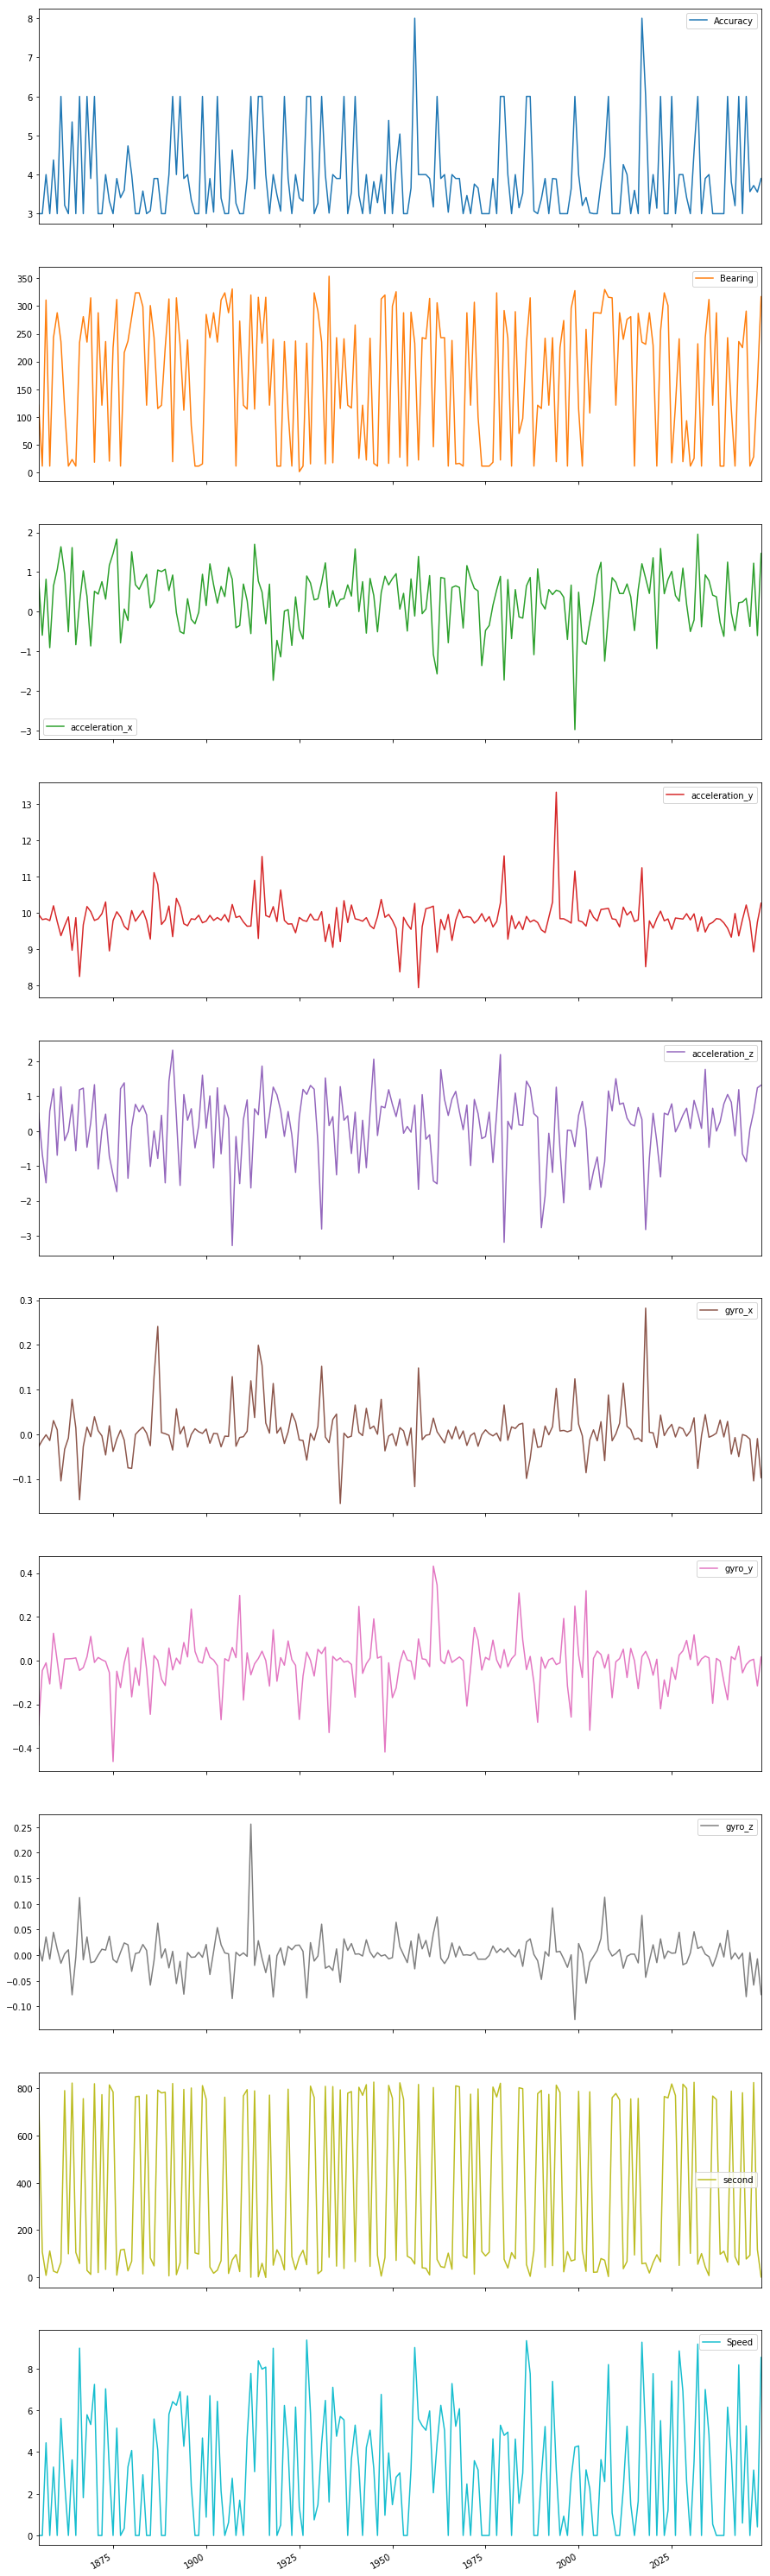

In [0]:
train_df[train_df['bookingID'] == 2][features].plot(subplots=True, sharex=True, figsize=(15,60))
plt.show()

In [0]:
# # explore an ID
# example = train_df[(train_df['bookingID'] == 0) |
#                    (train_df['bookingID'] == 1709396983975)]

# ids = example['bookingID'].unique()

# print(ids)

# # highest accuracy
# np.sort(example['Accuracy'].values)[::-1]

# example[example['Accuracy'] > 20]

In [0]:
# example.describe()

## Feature engineering
Some ideas are taken from this [discussion](https://www.kaggle.com/c/axa-driver-telematics-analysis/discussion/12848#latest-66913) and [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

In [0]:
def total_a(df):
    # acceleration combining all directions
    total_a = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_a'] = np.sqrt(total_a)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
def roll(df):
    # roll  
    yz = df[['acceleration_y', 'acceleration_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll'] = np.arctan2(y, z)
      
def pitch(df):
    # pitch
    xyz = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))
    
def horsepower(df):
    df['horsepower'] = df['total_a'] * df['Speed']
    
def aggressive_turn(df):
    pass
  
def jerk(df):
    pass
  
def a_threshold(df):
    # and difference > threshold
    pass  
  
def fe(df):
    total_a(df)
    total_gyro(df)
    roll(df)
    pitch(df)
    horsepower(df)

In [0]:
%%time
fe(train_df)

CPU times: user 4.55 s, sys: 3.41 s, total: 7.96 s
Wall time: 7.98 s


In [0]:
exclude = ['label', 'bookingID', 'unique_counts']

features = [c for c in train_df.columns if c not in exclude]

len(features)

# features

15

## Accuracy
Extract the `TOP_N` highest accuracy features.

In [0]:
@jit(nopython=True)
def accuracy_features(accuracy, feature, TOP_N=1):
    idxs = np.argsort(accuracy)[::-1][:TOP_N]
    return feature[idxs]

In [0]:
# %%time
# TOP_N_SPEED_2 = np.empty((len(ids), TOP_N))
# # TOP_N_HP = np.empty((len(ids), TOP_N))

# for i in tqdm(range(len(ids))):
#     accuracy = train_df[train_df['bookingID'] == ids[i]]['Accuracy'].values
#     features = train_df[train_df['bookingID'] == ids[i]]['Speed'].values

#     TOP_N_SPEED_2[i] = accuracy_features(accuracy, features, 3)    

In [0]:
def top_accuracy_f(bookingID, df, f, N=1):
  
    subset = df[df['bookingID'] == bookingID]   
    
    # get indices with top N highest accuracy
    idxs = np.argsort(subset['Accuracy'].values)[::-1][:N]    
    
    return subset.iloc[idxs][f].values.T

In [0]:
gc.collect()

28501

In [0]:
# %%time
# TOP_N = 3

# TOP_N_SPEED = np.empty((len(ids), TOP_N))
# TOP_N_HP = np.empty((len(ids), TOP_N))

# for i in range(len(ids)):
#     TOP_N_SPEED[i] = top_accuracy_f(ids[i], train_df, 'Speed', TOP_N)
#     TOP_N_HP[i] = top_accuracy_f(ids[i], train_df, 'horsepower', TOP_N)

## Normalization

In [0]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from tqdm import tqdm

# def normalize_by_ids(df):
#     drivers = df['bookingID'].unique()
#     for driver in tqdm(drivers):
#         ids = df[df['bookingID'] == driver].index
#         scaler = MinMaxScaler()
#         df.loc[ids, features] = scaler.fit_transform(df.loc[ids, features])
        
# normalize_by_ids(sub_df)

In [0]:
# =======
# differentiation features
# =======
def fo(x):
    return np.diff(x)

def so(x):
    return np.diff(fo(x))

def fo_mean(x):
    # first order diff mean
    return np.mean(fo(x))

def so_mean(x):
    # second order diff mean
    return np.mean(so(x))         

def fo_min(x):
    # first order diff min
    return np.min(fo(x))

def so_min(x):
    # second order diff min
    return np.min(so(x))   

def fo_max(x):
    # first order diff max
    return np.max(fo(x))

def so_max(x):
    # second order diff max
    return np.max(so(x))  

def sign_change(x):
    return sum(np.diff(np.sign(x)) != 0)

In [0]:
import itertools
# =======
# tsfresh functions
# =======

def count_above_mean(x):
    m = np.mean(x)
    return np.where(x > m)[0].size/len(x)

def absolute_sum_of_changes(x):
    return np.sum(np.abs(np.diff(x)))  
  
def kurtosis(x):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    return pd.Series.kurtosis(x)  

def _get_length_sequences_where(x):
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]

def mean_abs_change(x):
    return np.mean(np.abs(np.diff(x)))
      
def longest_strike_above_mean(x):
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.max(_get_length_sequences_where(x >= np.mean(x))) if x.size > 0 else 0
  
def _roll(a, shift):
    if not isinstance(a, np.ndarray):
          a = np.asarray(a)
    idx = shift % len(a)
    return np.concatenate([a[-idx:], a[:-idx]])
  
def number_peaks(x, n=3):
    x_reduced = x[n:-n]

    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > _roll(x, i)[n:-n])

        if res is None:
            res = result_first
        else:
            res &= result_first

        res &= (x_reduced > _roll(x, -i)[n:-n])
    return np.sum(res)

In [0]:
def agg_features(df, new_df):
  
    # statistical features
    func = ('max', 'mean', 'std')
    
    exclude = ('label', 'bookingID')

    # performed on all features
    features = (c for c in df.columns if c not in exclude)   
    
    for f in features:
        new = df.groupby('bookingID')[f].agg(func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
    
    print('Done statistical features...')
    
    subfeatures = ('acceleration_x', 'acceleration_y', 'acceleration_z',
                   'gyro_x', 'gyro_y', 'gyro_z',
                   'roll', 'pitch')

    
            
    print('Now to tsfresh features...')
    
    # ===
    # only perform tsfresh
    # features on the 6 important features
    # ===
    
    tsfresh_func = (count_above_mean, absolute_sum_of_changes,
                    kurtosis, mean_abs_change,
                    longest_strike_above_mean, number_peaks)

    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(tsfresh_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done tsfresh features...')
        
    print('Now to differentiation features...')
        
    # ===
    # only perform differentiation
    # features on the 6 important features
    # ===
        
    
    diff_func = (fo_mean, fo_min, fo_max,
                 so_mean, so_min, so_max,
                 sign_change)
        
    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(diff_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done differentiation features...')

                
    return new_df        

In [0]:
ids = train_df['bookingID'].unique()

new_df = pd.DataFrame()

new_df['bookingID'] = ids

len(new_df)

20000

In [0]:
%%time
sample_new = agg_features(train_df, new_df)

Done statistical features...
Now to tsfresh features...
Done tsfresh features...
Now to differentiation features...
Done differentiation features...
CPU times: user 18min 13s, sys: 1.96 s, total: 18min 15s
Wall time: 18min 14s


In [0]:
sample_new.head()

,bookingID,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_mean,gyro_z_std,second_max,second_mean,second_std,Speed_max,Speed_mean,Speed_std,total_a_max,total_a_mean,total_a_std,total_gyro_max,total_gyro_mean,total_gyro_std,roll_max,roll_mean,roll_std,...,acceleration_z_fo_max,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_mean,roll_fo_min,roll_fo_max,roll_so_mean,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_mean,pitch_fo_min,pitch_fo_max,pitch_so_mean,pitch_so_min,pitch_so_max,pitch_sign_change
0,0,48.000,10.165339,3.855898,359.979767,176.526099,129.231351,4.782614,-0.711264,0.928022,-6.119916,-9.613822,0.639934,2.318857,-1.619658,1.141266,0.438371,0.003328,0.065954,0.469724,-0.006118,0.100225,0.372807,-0.004188,0.063685,1589.0,903.526892,533.745097,22.946083,8.994822,7.199919,12.988328,9.886164,0.624159,0.749086,0.100772,0.091389,-1.347602,-1.737242,0.116742,...,6.332556,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,0.000171,-0.470042,0.615583,0.000202,-0.940743,1.047816,0.0,0.000157,-0.441226,0.505558,0.000210,-0.853901,0.918500,278.0
1,1,7.709,3.718763,0.597933,337.000000,124.198590,89.861236,3.813341,-0.525406,0.744157,12.536156,9.532086,0.533915,1.481293,-2.198999,0.854271,0.126536,-0.002467,0.027740,0.470837,-0.007540,0.091699,0.235131,0.000405,0.033838,1034.0,581.175088,289.339367,21.882141,7.881588,7.059362,12.790147,9.862507,0.519956,0.717864,0.066187,0.077463,2.137340,1.797626,0.088049,...,5.158748,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,-0.000096,-0.537245,0.523479,-0.000285,-0.783427,0.965273,0.0,0.000099,-0.488136,0.452367,-0.000123,-0.832619,0.931832,180.0
2,2,8.000,3.930626,1.117354,354.000000,173.794872,119.316520,1.956122,0.306786,0.756589,13.333716,9.843183,0.505693,2.312870,0.139347,1.020021,0.282162,0.006458,0.053903,0.431695,-0.012861,0.117321,0.255884,0.002597,0.036215,825.0,339.441026,356.319445,9.360483,3.157213,2.897762,13.403410,9.929590,0.515173,0.463685,0.097433,0.093028,1.891112,1.556422,0.102860,...,4.326454,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,-0.000391,-0.436176,0.478420,-0.000621,-0.777169,0.635099,0.0,-0.000304,-0.310418,0.329223,-0.001784,-0.639641,0.490599,80.0
3,4,10.000,10.000000,0.000000,353.855377,151.807013,71.273774,2.019635,-0.365117,0.527220,-7.064984,-9.406439,0.598023,0.296381,-2.613639,0.779529,0.438732,-0.022884,0.042342,0.652628,0.023232,0.112567,0.505220,-0.000376,0.065927,1094.0,547.495430,315.962793,19.780001,6.150996,5.595901,21.053265,9.813434,0.620066,0.661675,0.108875,0.089501,-1.537207,-1.841256,0.077592,...,6.575403,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.000110,-1.186005,1.002399,519.0,-0.000012,-0.481751,0.561944,0.000108,-1.043695,0.714401,536.0,-0.000184,-0.366293,0.371167,0.000134,-0.72819

In [0]:
def add_features(df, arr, f):
    for i in range(TOP_N):
        var = f + '_' + str(i+1)
        df[var] = arr[:, i]

# add the TOP_N accuracy features to the merged df
add_features(new, TOP_N_SPEED, 'Speed')
add_features(new, TOP_N_HP, 'horsepower')

In [0]:
# count = train_df.groupby('bookingID').count().iloc[:,0].values

# train_df['count'] = count

In [0]:
new_sub = pd.merge(sample_new, labels_df,
                  left_on='bookingID', right_on='bookingID',
                  how='inner')

new_sub.head()

,bookingID,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_mean,gyro_z_std,second_max,second_mean,second_std,Speed_max,Speed_mean,Speed_std,total_a_max,total_a_mean,total_a_std,total_gyro_max,total_gyro_mean,total_gyro_std,roll_max,roll_mean,roll_std,...,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_mean,roll_fo_min,roll_fo_max,roll_so_mean,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_mean,pitch_fo_min,pitch_fo_max,pitch_so_mean,pitch_so_min,pitch_so_max,pitch_sign_change,label
0,0,48.000,10.165339,3.855898,359.979767,176.526099,129.231351,4.782614,-0.711264,0.928022,-6.119916,-9.613822,0.639934,2.318857,-1.619658,1.141266,0.438371,0.003328,0.065954,0.469724,-0.006118,0.100225,0.372807,-0.004188,0.063685,1589.0,903.526892,533.745097,22.946083,8.994822,7.199919,12.988328,9.886164,0.624159,0.749086,0.100772,0.091389,-1.347602,-1.737242,0.116742,...,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,0.000171,-0.470042,0.615583,0.000202,-0.940743,1.047816,0.0,0.000157,-0.441226,0.505558,0.000210,-0.853901,0.918500,278.0,0
1,1,7.709,3.718763,0.597933,337.000000,124.198590,89.861236,3.813341,-0.525406,0.744157,12.536156,9.532086,0.533915,1.481293,-2.198999,0.854271,0.126536,-0.002467,0.027740,0.470837,-0.007540,0.091699,0.235131,0.000405,0.033838,1034.0,581.175088,289.339367,21.882141,7.881588,7.059362,12.790147,9.862507,0.519956,0.717864,0.066187,0.077463,2.137340,1.797626,0.088049,...,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,-0.000096,-0.537245,0.523479,-0.000285,-0.783427,0.965273,0.0,0.000099,-0.488136,0.452367,-0.000123,-0.832619,0.931832,180.0,1
2,2,8.000,3.930626,1.117354,354.000000,173.794872,119.316520,1.956122,0.306786,0.756589,13.333716,9.843183,0.505693,2.312870,0.139347,1.020021,0.282162,0.006458,0.053903,0.431695,-0.012861,0.117321,0.255884,0.002597,0.036215,825.0,339.441026,356.319445,9.360483,3.157213,2.897762,13.403410,9.929590,0.515173,0.463685,0.097433,0.093028,1.891112,1.556422,0.102860,...,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,-0.000391,-0.436176,0.478420,-0.000621,-0.777169,0.635099,0.0,-0.000304,-0.310418,0.329223,-0.001784,-0.639641,0.490599,80.0,1
3,4,10.000,10.000000,0.000000,353.855377,151.807013,71.273774,2.019635,-0.365117,0.527220,-7.064984,-9.406439,0.598023,0.296381,-2.613639,0.779529,0.438732,-0.022884,0.042342,0.652628,0.023232,0.112567,0.505220,-0.000376,0.065927,1094.0,547.495430,315.962793,19.780001,6.150996,5.595901,21.053265,9.813434,0.620066,0.661675,0.108875,0.089501,-1.537207,-1.841256,0.077592,...,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.000110,-1.186005,1.002399,519.0,-0.000012,-0.481751,0.561944,0.000108,-1.043695,0.714401,536.0,-0.000184,-0.366293,0.371167,0.000134,-0.728194,0.595339,0.0,0.000184,-0.325465,0.368603,-0.

In [0]:
new_sub.to_feather(f'{PATH_FEATURES}/sample_new_151')

## EDA

In [0]:
new_sub = pd.read_feather(f'{PATH_FEATURES}/sample_new_151')

train_df = new_sub.copy()

In [7]:
gc.collect()

7

In [37]:
cols = [c for c in train_df.columns if 'max' in c]

len(cols)

31

first: 0.0, last: 843.0


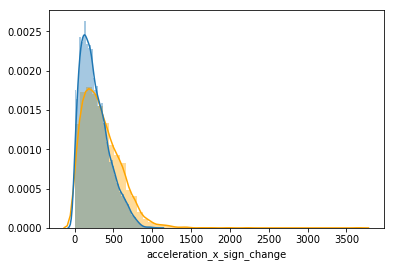

first: 0.0, last: 347.0099999999984


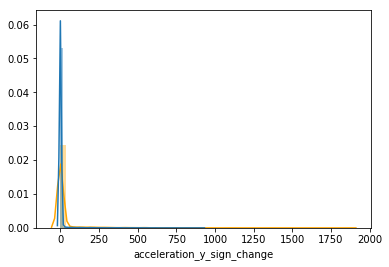

first: 0.0, last: 719.0


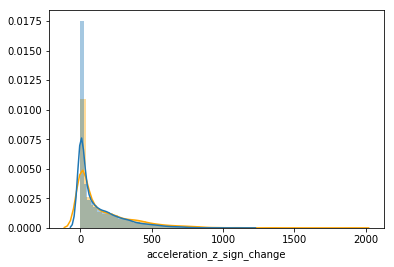

first: 59.0, last: 956.0299999999952


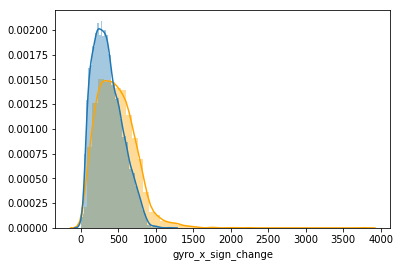

first: 61.0, last: 957.0099999999984


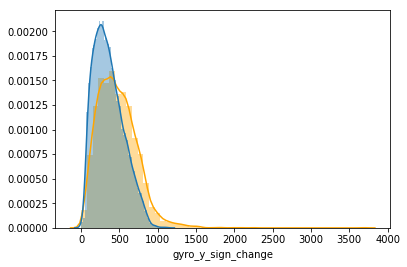

first: 59.0, last: 964.0


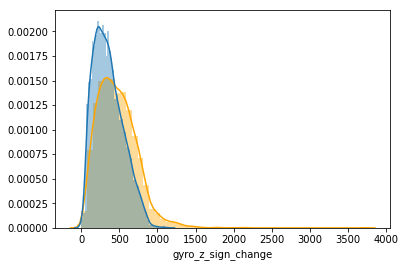

first: 0.0, last: 347.0099999999984


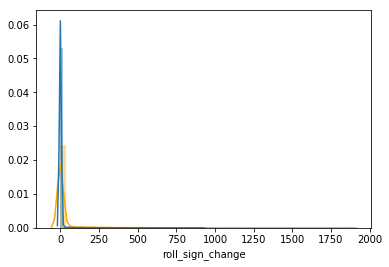

first: 0.0, last: 843.0


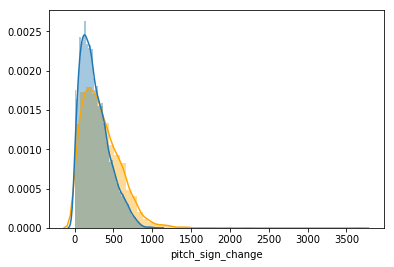

In [9]:
for col in cols:
    sample = train_df[[col, 'label']]

    # set outliers to the 1st and 99th quantile
    # winsorization
    last_quant = sample[col].quantile(.99)
    first_quant = sample[col].quantile(.01)
    
    print('first: {}, last: {}'.format(first_quant, last_quant))

    sample.loc[sample[col] > last_quant, col] = last_quant
    sample.loc[sample[col] < first_quant, col] = first_quant
    
    plt.figure(figsize=(6,4))
    sns.distplot(train_df[train_df['label']==1][col],color ='orange')
    sns.distplot(train_df[train_df['label']==0][col])
    plt.show()

In [0]:
for c in cols:
    c_median = train_df[c].median()
    above_median = train_df[train_df[c] > c_median]['bookingID'].tolist()
    
    train_df[c + '_above'] = 0
    
    train_df.loc[train_df['bookingID'].isin(above_median), c + '_above'] = 1

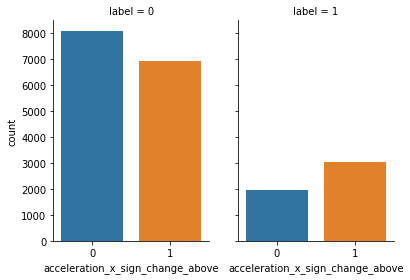

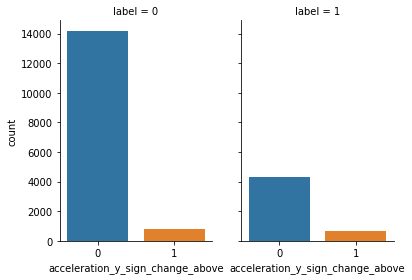

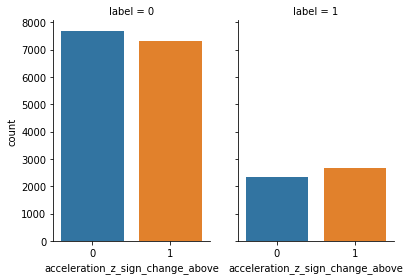

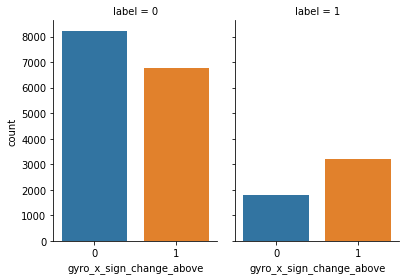

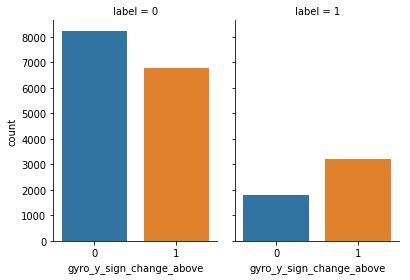

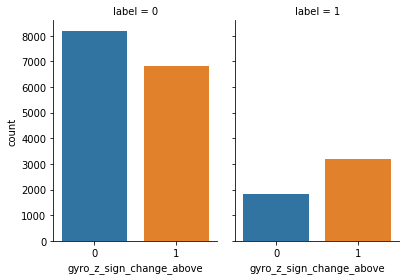

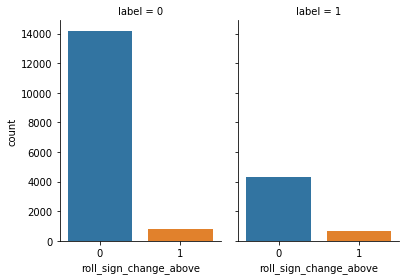

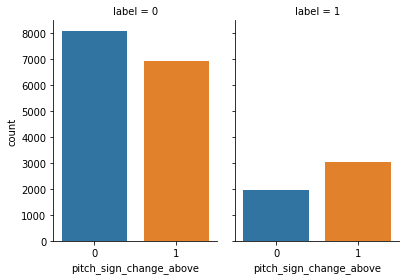

In [35]:
for c in cols:
    sns.catplot(x=c+"_above", col="label",
                data=train_df, kind="count",
                height=4, aspect=.7);

In [0]:
# plt.figure(figsize=(15,30))
# for i, col in enumerate(cols):
#     plt.subplot(10, 2, i+1)
#     sns.distplot(train_df[train_df['label']==1][col],color ='orange')
#     sns.distplot(train_df[train_df['label']==0][col])
#     plt.title(col)

In [0]:
features = [c for c in train_df.columns if c not in ['bookingID', 'label']]

In [0]:
len(features)

149

In [0]:
corrmat = train_df[features].corr()

corr_mat = corrmat[corrmat[features] > 0.05].fillna(-1)

corr_mat.head()

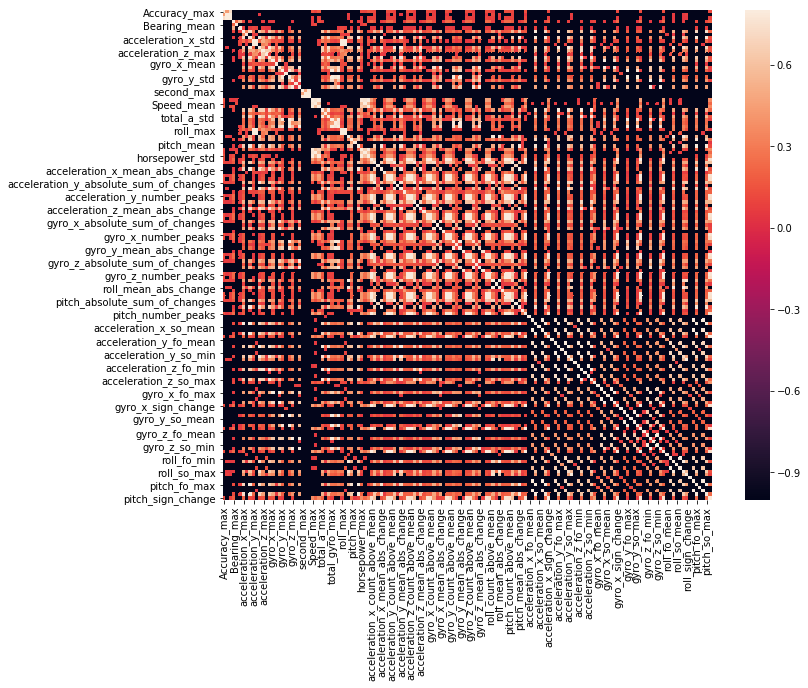

In [0]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

Check for outliers according to Chauvenet's criterion.

In [0]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [0]:
train_outliers = dict()

for col in features:
    train_outliers[col] = train_df[chauvenet(train_df[col].values)].shape[0]    

Create a dataframe for outliers.

In [0]:
outliers_df = pd.DataFrame.from_dict(train_outliers,
                                     orient='index')

outliers_df = outliers_df.reset_index()

outliers_df = outliers_df.rename(columns={'index': 'feature',
                                           0: 'num_outliers'})

outliers_df = outliers_df.sort_values('num_outliers', ascending=False)

outliers_df = outliers_df[:50]

outliers_df.head()

,feature,num_outliers
0,Accuracy_max,745
136,roll_fo_min,689
137,roll_fo_max,686
140,roll_so_max,636
39,pitch_max,628


Plot the `outliers_df`.

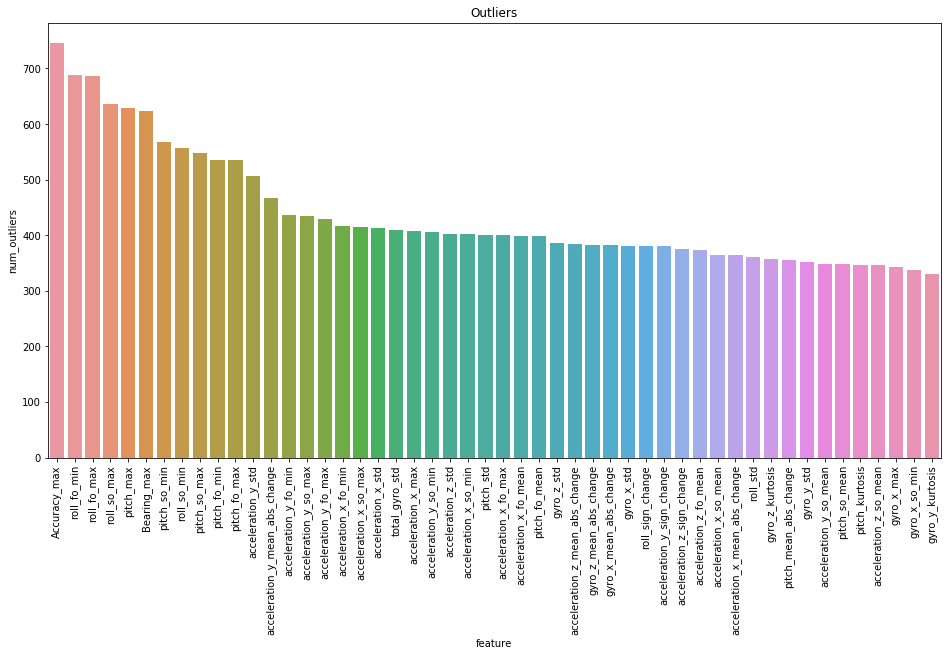

In [0]:
plt.figure(figsize=(16,8))
sns.barplot(x="feature", y="num_outliers", 
            data=outliers_df)
plt.xticks(rotation=90)
plt.title('Outliers')
plt.show()